In [ ]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL, urllib
import os
from PIL import Image
import pandas as pd

KeyboardInterrupt: 

In [ ]:
def get_diagnosis(image_name, file):

    matching_row = file[file['image_id'] == image_name.split('.')[0]]
    if not matching_row.empty:
        return matching_row.iloc[0]['dx']
    return None

def create_image_diagnosis_dict(base_path, folder, file):
    metadata = pd.read_csv(file)

    image_diagnosis_dict = {}
    path = base_path + folder
    print(path)
    for image_name in os.listdir(path):
        diagnosis = get_diagnosis(image_name, metadata)
        if diagnosis is not None:
            # Add the image name and its diagnosis to the dictionary
            image_diagnosis_dict[image_name] = diagnosis
    return image_diagnosis_dict

In [ ]:
class diagnoses(Dataset):
        CLASSES = ('nv', 'akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc')

        def __init__(self, data, transform=None):
            self.data = data
            self.transform = transform

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            image_path, label = self.data[idx]
            image = Image.open(image_path)
            if self.transform:
                image = self.transform(image)
            try:
                label_idx = self.CLASSES.index(label) if isinstance(label, str) else label
            except ValueError:
                print(f"Error with label: {label} at index: {idx}")
                raise
            return image, label_idx

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/APS360/Demo'
folders = ('/demo_images')
metadata = '/ISIC2018_Task3_Test_GroundTruth.csv'

dataset = []

matches = create_image_diagnosis_dict(base_path, folders, base_path + metadata)

/content/drive/MyDrive/APS360/Demo/demo_images


In [ ]:
def make_dataset(idx, base_path, folder, max_images=None):
    CLASSES = ('nv', 'akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc')
    dataset = []
    image_count = 0
    path = base_path + folder
    for img in sorted(os.listdir(path)):
        if max_images and image_count >= 200000:
            break
        image_path = os.path.join(path, img)
        label = idx.get(img)
        if label is None or label not in CLASSES:
            continue
        dataset.append((image_path, label))
        image_count += 1
    return dataset

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter

def get_data_loader_test(batch_size, idx, base_path, folders):

    transform = transforms.Compose([
        transforms.Resize((250,250)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = make_dataset(idx, base_path, folders, 50000)


    torch_test = diagnoses(dataset, transform)


    loader = torch.utils.data.DataLoader(torch_test, batch_size=batch_size,
                              num_workers=0)

    print("get data loader complete")

    return loader


In [ ]:
test_loader = get_data_loader_test(64, matches, base_path, folders)

get data loader complete


In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):

    path = "{0}_batch_{1}_lr_{2}_epoch_{3}.model".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(model, loader, criterion):
  model.eval()
  total_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
      for data, target in loader:
          if torch.cuda.is_available():
              data, target = data.cuda(), target.cuda()

          output = model(data)


          if isinstance(output, tuple):
              output = output[0]

          loss = criterion(output, target)
          total_loss += loss.item()

          _, predicted = torch.max(output.data, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()

  avg_loss = total_loss / len(loader)
  accuracy = correct / total
  return accuracy, avg_loss


In [ ]:
######################################################
##############  Primary Model 5.0  ###################
######################################################

import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, f1, f2, f3, f4, f5, f6):
        super(InceptionBlock, self).__init__()
        self.name = 'InceptionBlock'
        # Total output channels from all paths
        out_channels = f1 + f3 + f5 + f6


        self.conv1 = nn.Conv2d(in_channels, f1, kernel_size=1)
        self.conv3_1 = nn.Conv2d(in_channels, f2, kernel_size=1)
        self.conv3_2 = nn.Conv2d(f2, f3, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(in_channels, f4, kernel_size=5, padding=2)
        self.conv5_2 = nn.Conv2d(f4, f5, kernel_size=5, padding=2)  # Additional 5x5 conv for depth
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_conv = nn.Conv2d(in_channels, f6, kernel_size=1)
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        res = self.res_conv(x)

        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv3_1(x))
        x2 = F.relu(self.conv3_2(x2))
        x3 = F.relu(self.conv5_1(x))
        x3 = F.relu(self.conv5_2(x3))
        x4 = self.pool(x)
        x4 = F.relu(self.pool_conv(x4))

        out = torch.cat([x1, x2, x3, x4], dim=1)
        out += res  # Adding the residual connection
        return F.relu(out)

class AuxModel(nn.Module):
    def __init__(self):
        super(AuxModel, self).__init__()
        self.name = 'AuxModel'
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.inception1 = InceptionBlock(64, 16, 24, 32, 16, 32, 32)
        self.inception2 = InceptionBlock(112, 32, 48, 64, 32, 64, 32)
        self.inception3 = InceptionBlock(192, 64, 96, 128, 64, 128, 64)

        self.dilated_conv = nn.Conv2d(384, 512, kernel_size=3, stride=1, padding=2, dilation=2)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Main classification layer
        self.fc1 = nn.Linear(512, 300)
        self.fc2 = nn.Linear(300, 150)
        self.fc3 = nn.Linear(150, 50)
        self.fc4 = nn.Linear(50, 7)
        # Auxiliary branch
        self.auxiliary_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.auxiliary_fc1 = nn.Linear(192, 100)
        self.auxiliary_fc2 = nn.Linear(100, 7)  # Assuming the aux output has the same number of classes

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.inception1(x)
        x = self.maxpool(x)

        # Save the output after the second inception block for the auxiliary branch
        aux = self.inception2(x)
        x = self.maxpool(aux)

        x = self.inception3(x)

        x = self.dilated_conv(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        main_output = self.fc4(x)


        # Auxiliary branch computations
        aux = self.auxiliary_avgpool(aux)
        aux = torch.flatten(aux, 1)
        aux = F.relu(self.auxiliary_fc1(aux))
        aux_output = self.auxiliary_fc2(aux)

        return main_output, aux_output

In [ ]:
primary_model = AuxModel()
if torch.cuda.is_available():
    primary_model.cuda()

bs = 64
lr = 0.03
epochs = 50
model_path = '/content/drive/MyDrive/APS360/Demo/Model5.pt'


primary_model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))
primary_model.eval()

AuxModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (inception1): InceptionBlock(
    (conv1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (conv3_1): Conv2d(64, 24, kernel_size=(1, 1), stride=(1, 1))
    (conv3_2): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5_1): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv5_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (pool_conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (res_conv): Conv2d(64, 112, kernel_size=(1, 1), stride=(1, 1))
  )
  (inception2): InceptionBlock(
    (conv1): Conv2d(112, 32, kernel_size=(1, 1), stride=(1, 1))
    (conv3_1): Conv2d(112, 48, kernel_size=(1, 1), stride=(1, 1))
    (conv3_2): Conv2d(48, 64, kerne

In [ ]:
def get_predictions(model, data_loader):
    model.eval()
    device = next(model.parameters()).device
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            main_output = outputs[0]
            _, predicted = torch.max(main_output.data, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

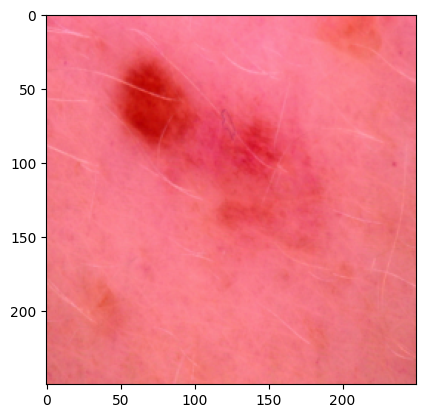

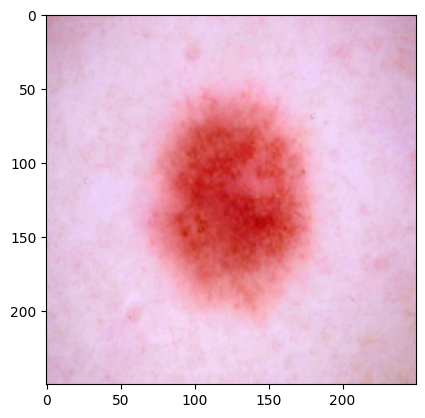

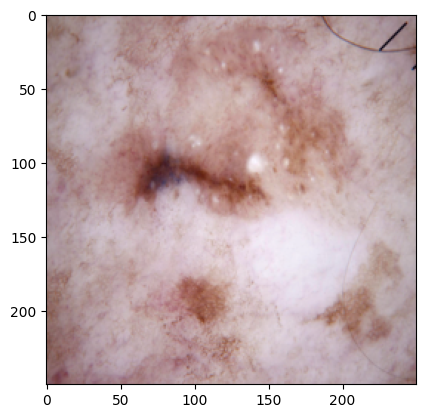

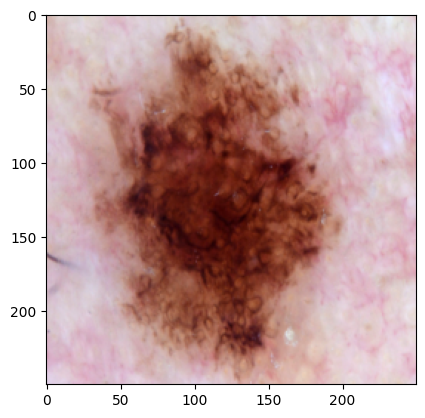

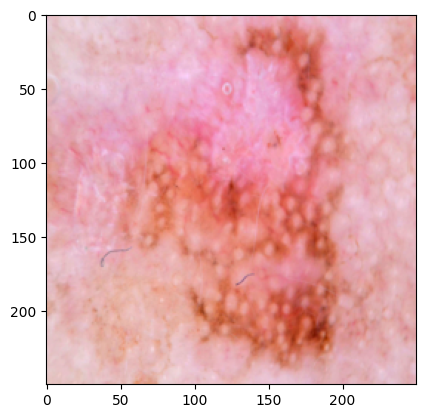

In [ ]:
for images, labels in test_loader:
    for i in range(len(images)):

        single_image_tensor = images[i]

        single_image_tensor = (single_image_tensor - single_image_tensor.min()) / (single_image_tensor.max() - single_image_tensor.min())

        plt.imshow(single_image_tensor.permute(1, 2, 0).numpy())
        plt.show()

In [ ]:
predictions, ground_truth = get_predictions(primary_model, test_loader)

In [ ]:
predictions

[0, 2, 3, 5, 1]

In [ ]:
ground_truth

[0, 0, 3, 5, 1]

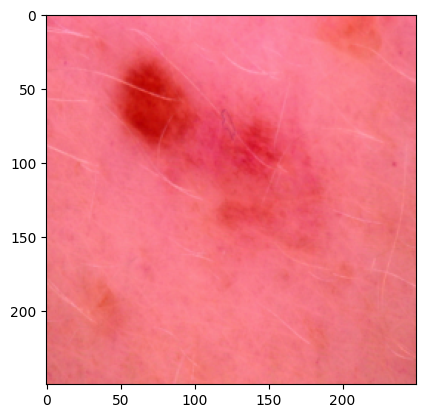

ground truth is melanocytic nevi(not cancer)
model predicted melanocytic nevi(not cancer) 








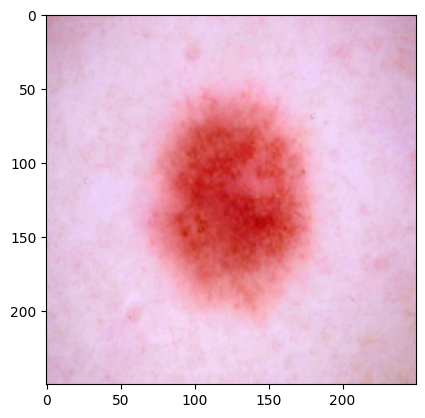

ground truth is melanocytic nevi(not cancer)
model predicted basal cell carcinoma(cancer) 








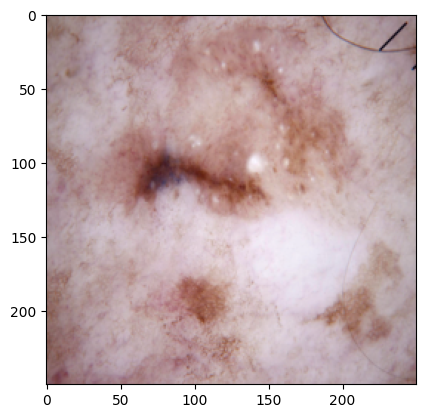

ground truth is benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses(not cancer)
model predicted benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses(not cancer) 








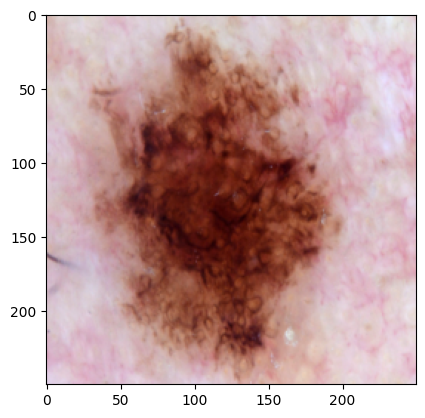

ground truth is melanoma(cancer)
model predicted melanoma(cancer) 








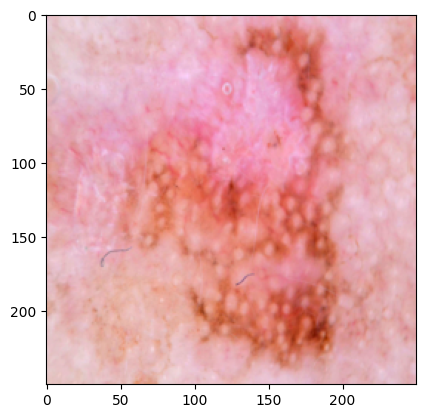

ground truth is actinic keratoses and intraepithelial carcinoma / Bowen's disease(cancer)
model predicted actinic keratoses and intraepithelial carcinoma / Bowen's disease(cancer) 








In [ ]:
CLASSES = ('melanocytic nevi(not cancer)', 'actinic keratoses and intraepithelial carcinoma / Bowen\'s disease(cancer)', 'basal cell carcinoma(cancer)', 'benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses(not cancer)', 'dermatofibroma(not cancer)', 'melanoma(cancer)', 'vascular lesions(not cancer)')

for images, labels in test_loader:
    for i in range(len(images)):

        single_image_tensor = images[i]

        single_image_tensor = (single_image_tensor - single_image_tensor.min()) / (single_image_tensor.max() - single_image_tensor.min())

        plt.imshow(single_image_tensor.permute(1, 2, 0).numpy())
        plt.show()
        print("ground truth is", CLASSES[labels[i].item()])
        print("model predicted", CLASSES[predictions[i]],"\n\n\n\n\n\n")